# Multiomics AI analysis

## Overview
This notebook implements:
- **Phase 1**: Data loading, preprocessing, and quality control
- **Phase 2**: Single-omics analysis
  - Differential Expression Analysis (DESeq2 approach in Python)
  - Genetic Association Analysis (eQTL mapping)

## Dataset
- 300 samples (200 ASD cases, 100 controls)
- 50 SNPs from WGS data
- 20 genes from bulk RNA-seq (2 batches of 10 genes each)
- Clinical and demographic covariates

---
## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, fisher_exact, chi2_contingency
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

# Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Set random seed for reproducibility
np.random.seed(42)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ All libraries imported successfully
NumPy version: 1.26.4
Pandas version: 2.2.3


---
# PHASE 1: DATA PREPROCESSING & QUALITY CONTROL

## 1.1 Load All Dataset Files

In [14]:
# Define data directory
DATA_DIR = "../data/ASD_dataset/"

print("Loading dataset files...\n")

# Load covariates and clinical data
covariates = pd.read_csv(f"{DATA_DIR}ASD_covariates.csv")
print(f"✓ Loaded covariates: {covariates.shape[0]} samples, {covariates.shape[1]} variables")

# Load genotype data
genotypes = pd.read_csv(f"{DATA_DIR}ASD_genotypes.csv")
print(f"✓ Loaded genotypes: {genotypes.shape[0]} samples, {genotypes.shape[1]-1} SNPs")

# Load expression data (two batches)
expression = pd.read_csv(f"{DATA_DIR}ASD_expression1.csv")
print(f"✓ Loaded expression: {expression.shape[0]} samples, {expression.shape[1]-1} genes")

# Load annotations
gene_annotations = pd.read_csv(f"{DATA_DIR}ASD_gene_annotations.csv")
snp_annotations = pd.read_csv(f"{DATA_DIR}ASD_snp_annotations.csv")
print(f"✓ Loaded gene annotations: {len(gene_annotations)} genes annotated")
print(f"✓ Loaded SNP annotations: {len(snp_annotations)} SNPs annotated")

print("\n" + "="*80)
print("ALL DATA LOADED SUCCESSFULLY")
print("="*80)


Loading dataset files...

✓ Loaded covariates: 300 samples, 29 variables
✓ Loaded genotypes: 300 samples, 50 SNPs
✓ Loaded expression: 300 samples, 10 genes
✓ Loaded gene annotations: 12 genes annotated
✓ Loaded SNP annotations: 40 SNPs annotated

ALL DATA LOADED SUCCESSFULLY


## 1.2 Data Quality Assessment

In [15]:
print("QUALITY CONTROL CHECKS\n")
print("="*80)

# Check 1: Sample consistency across datasets
print("\n1. Sample ID Consistency Check:")
samples_cov = set(covariates['sample'])
samples_geno = set(genotypes['sample'])
samples_expr = set(expression['sample'])

all_samples_match = (samples_cov == samples_geno == samples_expr)
print(f"   All datasets have matching samples: {all_samples_match}")
print(f"   Total unique samples: {len(samples_cov)}")

# Check 2: Missing values
print("\n2. Missing Value Check:")
print(f"   Covariates missing: {covariates.isnull().sum().sum()}")
print(f"   Genotypes missing: {genotypes.isnull().sum().sum()}")
print(f"   Expression missing: {expression.isnull().sum().sum()}")

# Check 3: Data type verification
print("\n3. Data Type Verification:")
print(f"   Genotypes are numeric (0/1/2): {genotypes.iloc[:, 1:].isin([0, 1, 2]).all().all()}")
print(f"   Expression values are float: {expression.iloc[:, 1:].dtypes.apply(lambda x: x.kind == 'f').all()}")

# Check 4: Clinical variable distributions
print("\n4. Clinical Variables Summary:")
print(f"   ASD cases: {covariates['ASD'].sum()} ({100*covariates['ASD'].mean():.1f}%)")
print(f"   Controls: {(1-covariates['ASD']).sum()} ({100*(1-covariates['ASD'].mean()):.1f}%)")
print(f"   Sex ratio (% Male): {100*covariates['Sex'].mean():.1f}%")
print(f"   Age range: {covariates['Age'].min():.1f} - {covariates['Age'].max():.1f} years")
print(f"   IQ range: {covariates['IQ'].min():.1f} - {covariates['IQ'].max():.1f}")

print("\n" + "="*80)
print("QUALITY CONTROL PASSED ✓")
print("="*80)

QUALITY CONTROL CHECKS


1. Sample ID Consistency Check:
   All datasets have matching samples: True
   Total unique samples: 300

2. Missing Value Check:
   Covariates missing: 0
   Genotypes missing: 0
   Expression missing: 0

3. Data Type Verification:
   Genotypes are numeric (0/1/2): True
   Expression values are float: False

4. Clinical Variables Summary:
   ASD cases: 200 (66.7%)
   Controls: 100 (33.3%)
   Sex ratio (% Male): 67.7%
   Age range: 3.0 - 18.0 years
   IQ range: 45.0 - 141.0

QUALITY CONTROL PASSED ✓


## 1.3 Merge Expression Data and Prepare Combined Dataset

In [16]:
# Create master dataset with sample IDs aligned
# We'll keep separate DataFrames for different omics layers but ensure sample order is consistent

# Set sample as index for easier merging
covariates_indexed = covariates.set_index('sample')
genotypes_indexed = genotypes.set_index('sample')
expression_indexed = expression.set_index('sample')

# Verify all indices match
assert (covariates_indexed.index.equals(genotypes_indexed.index)) and (genotypes_indexed.index.equals(expression_indexed.index)), \
    "Sample indices do not match across datasets!"

print("✓ All datasets aligned by sample ID")
print(f"  - Covariates: {covariates_indexed.shape}")
print(f"  - Genotypes: {genotypes_indexed.shape}")
print(f"  - Expression: {expression_indexed.shape}")

✓ All datasets aligned by sample ID
  - Covariates: (300, 28)
  - Genotypes: (300, 50)
  - Expression: (300, 10)


## 1.4 Exploratory Data Analysis - Sample Characteristics

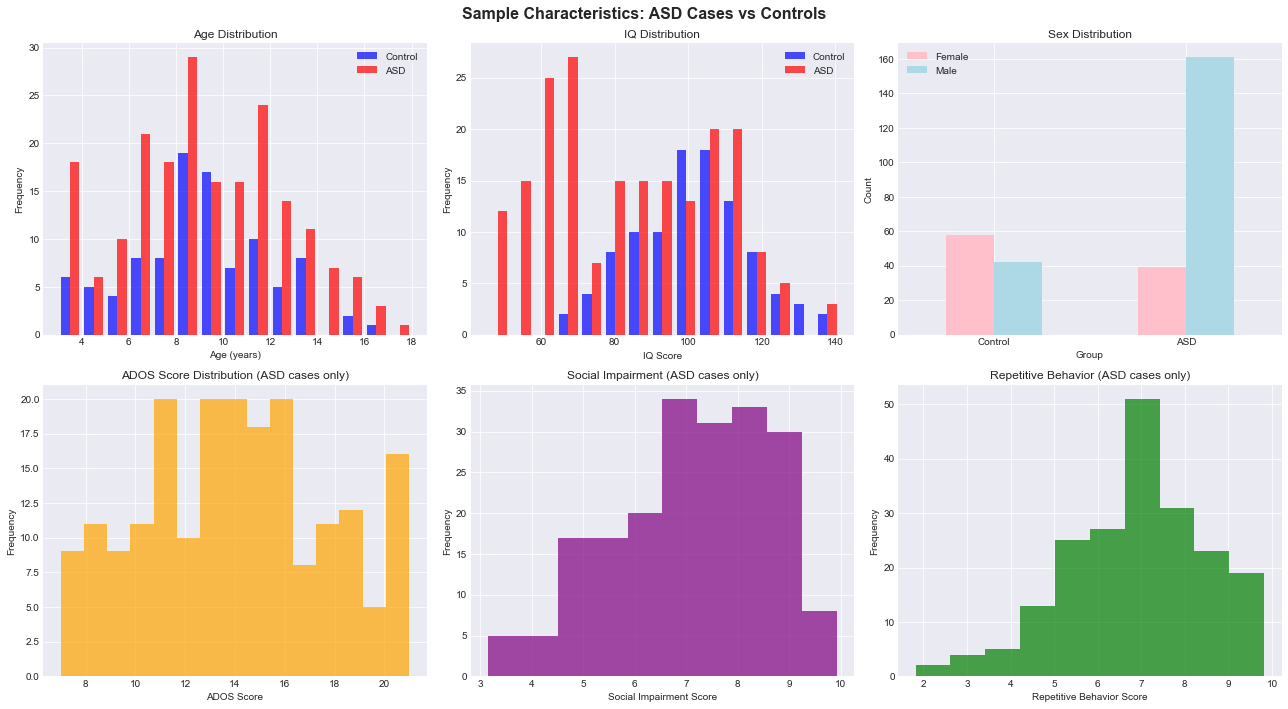

✓ Sample characteristics visualized and saved


In [17]:
# Create visualization of sample characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Sample Characteristics: ASD Cases vs Controls', fontsize=16, fontweight='bold')

# 1. Age distribution
asd_samples = covariates_indexed[covariates_indexed['ASD'] == 1]
ctrl_samples = covariates_indexed[covariates_indexed['ASD'] == 0]

axes[0, 0].hist([ctrl_samples['Age'], asd_samples['Age']], 
                bins=15, label=['Control', 'ASD'], alpha=0.7, color=['blue', 'red'])
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].legend()

# 2. IQ distribution
axes[0, 1].hist([ctrl_samples['IQ'], asd_samples['IQ']], 
                bins=15, label=['Control', 'ASD'], alpha=0.7, color=['blue', 'red'])
axes[0, 1].set_xlabel('IQ Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('IQ Distribution')
axes[0, 1].legend()

# 3. Sex distribution
sex_counts = covariates_indexed.groupby(['ASD', 'Sex']).size().unstack()
sex_counts.plot(kind='bar', ax=axes[0, 2], color=['pink', 'lightblue'])
axes[0, 2].set_xlabel('Group')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Sex Distribution')
axes[0, 2].set_xticklabels(['Control', 'ASD'], rotation=0)
axes[0, 2].legend(['Female', 'Male'])

# 4. ADOS Score (ASD only)
axes[1, 0].hist(asd_samples['ADOS_Score'], bins=15, color='orange', alpha=0.7)
axes[1, 0].set_xlabel('ADOS Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('ADOS Score Distribution (ASD cases only)')

# 5. Social Impairment
axes[1, 1].hist(asd_samples['Social_Impairment'], bins=10, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Social Impairment Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Social Impairment (ASD cases only)')

# 6. Repetitive Behavior
axes[1, 2].hist(asd_samples['Repetitive_Behavior'], bins=10, color='green', alpha=0.7)
axes[1, 2].set_xlabel('Repetitive Behavior Score')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Repetitive Behavior (ASD cases only)')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/QC_sample_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Sample characteristics visualized and saved")

## 1.5 Statistical Tests for Covariate Balance

In [18]:
print("Testing for Covariate Balance between ASD and Control Groups\n")
print("="*80)

# Age comparison (t-test)
age_stat, age_pval = stats.ttest_ind(ctrl_samples['Age'], asd_samples['Age'])
print(f"Age:")
print(f"  Control: {ctrl_samples['Age'].mean():.2f} ± {ctrl_samples['Age'].std():.2f}")
print(f"  ASD:     {asd_samples['Age'].mean():.2f} ± {asd_samples['Age'].std():.2f}")
print(f"  p-value: {age_pval:.4f}\n")

# Sex comparison (Chi-square)
sex_contingency = pd.crosstab(covariates_indexed['ASD'], covariates_indexed['Sex'])
chi2, sex_pval, dof, expected = chi2_contingency(sex_contingency)
print(f"Sex:")
print(f"  Control: {100*ctrl_samples['Sex'].mean():.1f}% Male")
print(f"  ASD:     {100*asd_samples['Sex'].mean():.1f}% Male")
print(f"  p-value: {sex_pval:.4f} (Chi-square test)\n")

# IQ comparison (t-test)
iq_stat, iq_pval = stats.ttest_ind(ctrl_samples['IQ'], asd_samples['IQ'])
print(f"IQ:")
print(f"  Control: {ctrl_samples['IQ'].mean():.2f} ± {ctrl_samples['IQ'].std():.2f}")
print(f"  ASD:     {asd_samples['IQ'].mean():.2f} ± {asd_samples['IQ'].std():.2f}")
print(f"  p-value: {iq_pval:.4e}\n")

print("="*80)
print("NOTE: Significant differences in IQ and Sex are expected for ASD")
print("      These will be included as covariates in downstream analyses")
print("="*80)

Testing for Covariate Balance between ASD and Control Groups

Age:
  Control: 8.99 ± 2.95
  ASD:     9.16 ± 3.42
  p-value: 0.6698

Sex:
  Control: 42.0% Male
  ASD:     80.5% Male
  p-value: 0.0000 (Chi-square test)

IQ:
  Control: 101.64 ± 15.33
  ASD:     83.95 ± 23.08
  p-value: 2.5053e-11

NOTE: Significant differences in IQ and Sex are expected for ASD
      These will be included as covariates in downstream analyses


## 1.6 Expression Data Quality Control

Expression Data Quality Metrics

Expression value summary statistics:
         gene_1      gene_2      gene_3       gene_4     gene_5     gene_6  \
mean   7.820000  174.180000  275.036667  1052.573333  31.810000   1.703333   
std    5.640359   79.560252  130.051477   537.601397  14.524822   2.302098   
min    0.000000   29.000000   67.000000   279.000000   4.000000   0.000000   
max   41.000000  430.000000  735.000000  2927.000000  88.000000  12.000000   

          gene_7      gene_8      gene_9       gene_10  
mean  336.086667  304.330000   95.496667  33088.390000  
std   190.215999  128.371304   45.261596  17294.027881  
min    91.000000   49.000000   19.000000   6645.000000  
max   973.000000  776.000000  267.000000  96848.000000  


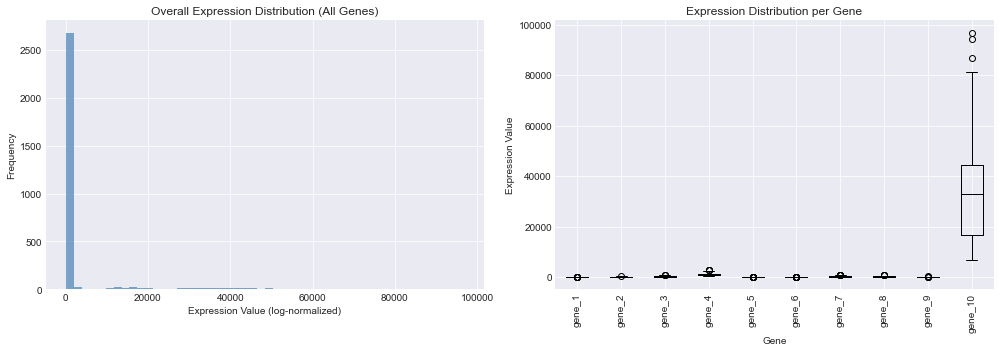


✓ Expression QC complete


In [19]:
# Check expression value distributions
print("Expression Data Quality Metrics\n")

# Summary statistics
expr_stats = expression_indexed.describe()
print("Expression value summary statistics:")
print(expr_stats.loc[['mean', 'std', 'min', 'max']])

# Plot expression distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
expression_indexed.values.flatten().reshape(-1, 1)
axes[0].hist(expression_indexed.values.flatten(), bins=50, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Expression Value (log-normalized)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Overall Expression Distribution (All Genes)')

# Per-gene boxplot (first 20 genes)
expression_indexed.iloc[:, :20].boxplot(ax=axes[1], rot=90, color='black')
axes[1].set_xlabel('Gene')
axes[1].set_ylabel('Expression Value')
axes[1].set_title('Expression Distribution per Gene')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/QC_expression_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Expression QC complete")

## 1.7 Genotype Data Quality Control

Genotype Data Quality Metrics

Number of SNPs: 50
Mean allele frequency: 0.241
Min allele frequency: 0.007
Max allele frequency: 0.500

Monomorphic SNPs (no variation): 0


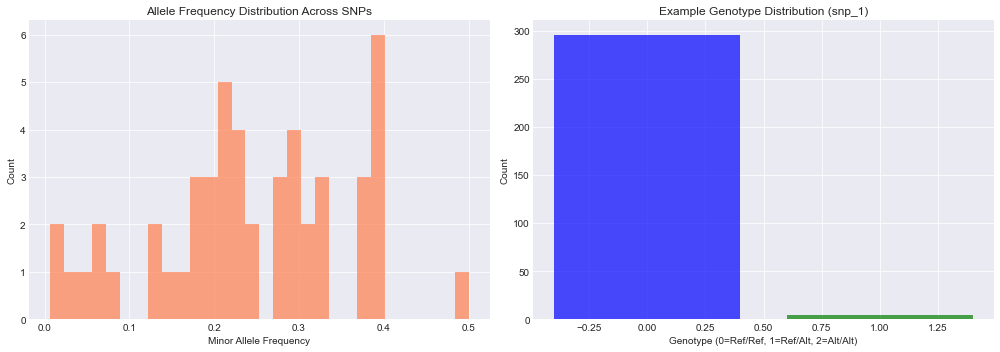


✓ Genotype QC complete


In [20]:
print("Genotype Data Quality Metrics\n")

# Calculate allele frequencies
allele_freqs = genotypes_indexed.mean() / 2  # Convert dosage to allele frequency
maf = allele_freqs.clip(upper=0.5)

print(f"Number of SNPs: {len(allele_freqs)}")
print(f"Mean allele frequency: {maf.mean():.3f}")
print(f"Min allele frequency: {maf.min():.3f}")
print(f"Max allele frequency: {maf.max():.3f}\n")

# Check for monomorphic SNPs (should have variation)
monomorphic_snps = genotypes_indexed.columns[genotypes_indexed.std() == 0]
print(f"Monomorphic SNPs (no variation): {len(monomorphic_snps)}")

# Plot allele frequency distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(maf, bins=30, alpha=0.7, color='coral')
axes[0].set_xlabel('Minor Allele Frequency')
axes[0].set_ylabel('Count')
axes[0].set_title('Allele Frequency Distribution Across SNPs')

# Genotype distribution for first SNP as example
genotype_counts = genotypes_indexed.iloc[:, 0].value_counts().sort_index()
# Handle cases where not all genotypes are present
genotype_labels = genotype_counts.index.tolist()
genotype_values = genotype_counts.values.tolist()
colors_map = {0: 'blue', 1: 'green', 2: 'red'}
bar_colors = [colors_map[g] for g in genotype_labels]
axes[1].bar(genotype_labels, genotype_values, color=bar_colors, alpha=0.7)
axes[1].set_xlabel('Genotype (0=Ref/Ref, 1=Ref/Alt, 2=Alt/Alt)')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Example Genotype Distribution ({genotypes_indexed.columns[0]})')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/QC_genotype_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Genotype QC complete")

## 1.8 Principal Component Analysis for Population Structure

Performing PCA on genotype data to check for population structure...



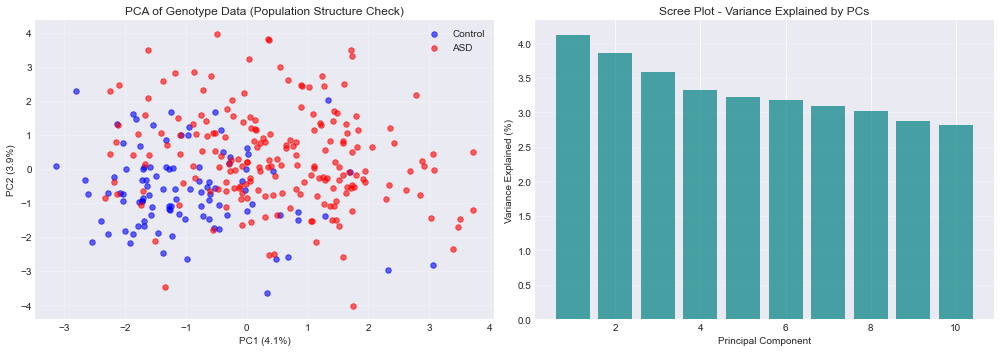


Variance explained by first 5 PCs: 18.12%

✓ PCA analysis complete
  Note: First 3 PCs will be used as covariates in association analyses


In [21]:
print("Performing PCA on genotype data to check for population structure...\n")

# Standardize genotype data
scaler = StandardScaler()
genotypes_scaled = scaler.fit_transform(genotypes_indexed)

# Perform PCA
pca = PCA(n_components=10)
pcs = pca.fit_transform(genotypes_scaled)

# Create DataFrame with PCs
pc_df = pd.DataFrame(
    pcs[:, :5],
    index=genotypes_indexed.index,
    columns=[f'PC{i+1}' for i in range(5)]
)

# Add ASD status for visualization
pc_df['ASD'] = covariates_indexed['ASD']

# Plot first two PCs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PC1 vs PC2 colored by ASD status
for status, label, color in [(0, 'Control', 'blue'), (1, 'ASD', 'red')]:
    mask = pc_df['ASD'] == status
    axes[0].scatter(pc_df.loc[mask, 'PC1'], pc_df.loc[mask, 'PC2'], 
                    label=label, alpha=0.6, s=30, color=color)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('PCA of Genotype Data (Population Structure Check)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scree plot
axes[1].bar(range(1, 11), pca.explained_variance_ratio_[:10] * 100, alpha=0.7, color='teal')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Variance Explained (%)')
axes[1].set_title('Scree Plot - Variance Explained by PCs')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/QC_genotype_PCA.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVariance explained by first 5 PCs: {pca.explained_variance_ratio_[:5].sum()*100:.2f}%")
print("\n✓ PCA analysis complete")
print("  Note: First 3 PCs will be used as covariates in association analyses")

# Save PCs for later use
pc_df_save = pc_df.drop(columns=['ASD'])
genotype_pcs = pc_df_save.copy()  # Store for later use

---
# PHASE 2: SINGLE-OMICS ANALYSIS

## 2.1 Differential Expression Analysis

In [27]:
!cd .. && python DESeq2_docker.py
de_results_df = pd.read_csv('../data/ASD_dataset/DESeq2_results.csv')

Preparing data for DESeq2 Analysis

✓ Loaded expression data: (300, 10)
✓ Loaded covariates data: (300, 28)
✓ Data prepared for DESeq2
  Count matrix shape: (300, 10)
  Sample metadata shape: (300, 4)
✓ R script created

Running DESeq2 using Docker container...
(This may take a few minutes on first run while pulling the image)

Running command: docker run --rm -v /Users/vladimirk/repositories/multiomics/data/ASD_dataset:/data getwilds/deseq2 Rscript /data/run_deseq2.R

Count data range: 0 to 96848
Mean count: 3536.7
Any NA values: FALSE

DESeq2 Analysis Complete
Total genes tested: 10
Significant DEGs (padj < 0.05): 9
Upregulated in ASD: 6
Downregulated in ASD: 3

Top 10 Differentially Expressed Genes:
           Gene log2FoldChange        pvalue          padj Significant
gene_3   gene_3    1.498824999  0.000000e+00  0.000000e+00        TRUE
gene_7   gene_7   -0.924343517  0.000000e+00  0.000000e+00        TRUE
gene_10 gene_10    1.881252627  0.000000e+00  0.000000e+00        TRUE
gene

## 2.1.1 Volcano Plot

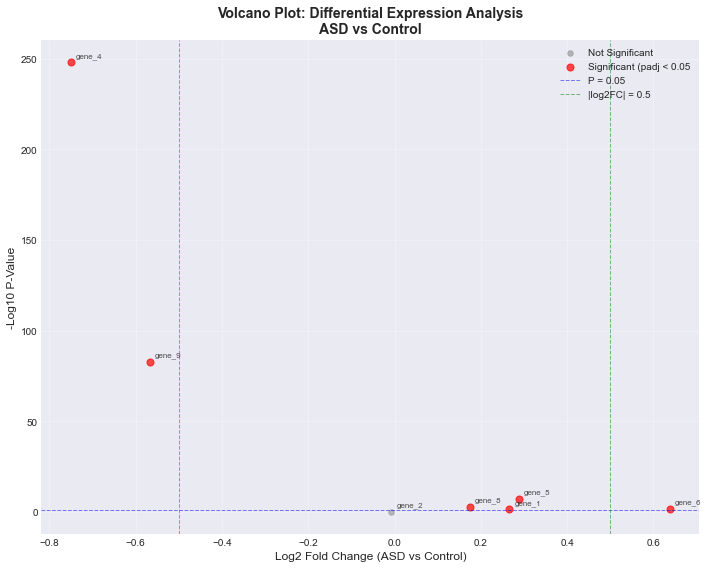

✓ Volcano plot saved


In [28]:
# Create volcano plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all genes
significant = de_results_df['Significant']
ax.scatter(de_results_df.loc[~significant, 'log2FoldChange'], 
           -np.log10(de_results_df.loc[~significant, 'padj']),
           c='gray', alpha=0.5, s=30, label='Not Significant')

# Plot significant genes
ax.scatter(de_results_df.loc[significant, 'log2FoldChange'], 
           -np.log10(de_results_df.loc[significant, 'padj']),
           c='red', alpha=0.7, s=50, label='Significant (padj < 0.05')

# Add gene labels for top significant genes
top_genes = de_results_df.nsmallest(10, 'padj')
for _, row in top_genes.iterrows():
    ax.annotate(row['Gene'], 
                xy=(row['log2FoldChange'], -np.log10(row['padj'])),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

# Add threshold lines
ax.axhline(-np.log10(0.05), color='blue', linestyle='--', alpha=0.5, linewidth=1, label='P = 0.05')
ax.axvline(-0.5, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax.axvline(0.5, color='green', linestyle='--', alpha=0.5, linewidth=1, label='|log2FC| = 0.5')

ax.set_xlabel('Log2 Fold Change (ASD vs Control)', fontsize=12)
ax.set_ylabel('-Log10 P-Value', fontsize=12)
ax.set_title('Volcano Plot: Differential Expression Analysis\nASD vs Control', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/ASD_dataset/DE_volcano_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Volcano plot saved")

## 2.1.2 Heatmap of Top Differentially Expressed Genes

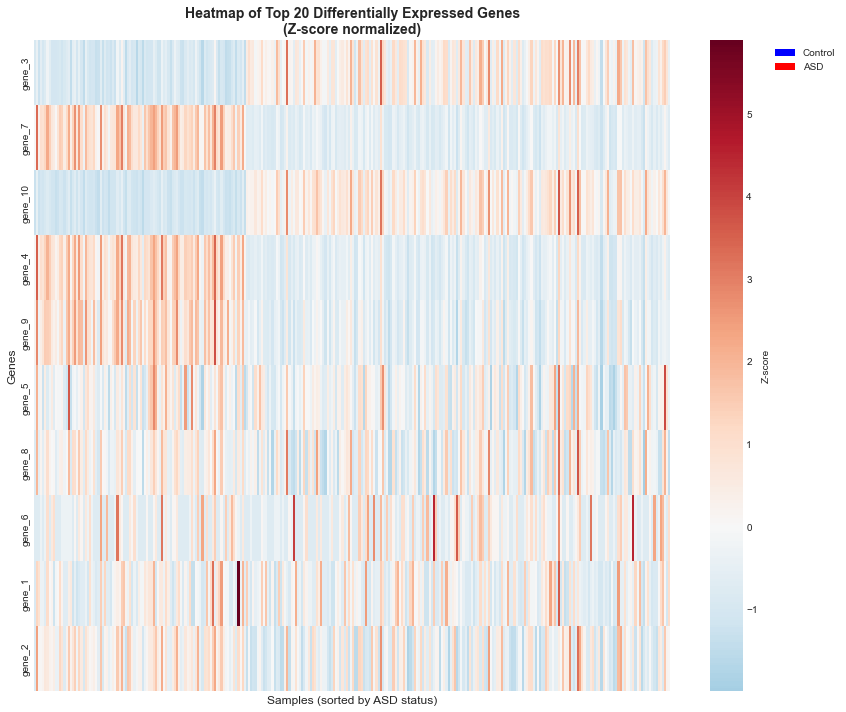

✓ Heatmap saved


In [29]:
# Select top 20 DEGs by p-value
top_degs = de_results_df.nsmallest(20, 'padj')['Gene'].tolist()

# Get expression data for these genes
expr_top = expression_indexed[top_degs]

# Add ASD status for sorting
expr_top_with_status = expr_top.copy()
expr_top_with_status['ASD'] = covariates_indexed['ASD']

# Sort by ASD status
expr_top_sorted = expr_top_with_status.sort_values('ASD').drop(columns=['ASD'])

# Z-score normalization for visualization
from scipy.stats import zscore
expr_top_zscore = expr_top_sorted.apply(zscore, axis=0)

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Create annotation colors for ASD status
asd_status = covariates_indexed.loc[expr_top_sorted.index, 'ASD']
row_colors = ['red' if x == 1 else 'blue' for x in asd_status]

# Plot heatmap
sns.heatmap(expr_top_zscore.T, 
            cmap='RdBu_r', 
            center=0,
            cbar_kws={'label': 'Z-score'},
            yticklabels=True,
            xticklabels=False,
            ax=ax)

ax.set_xlabel('Samples (sorted by ASD status)', fontsize=12)
ax.set_ylabel('Genes', fontsize=12)
ax.set_title('Heatmap of Top 20 Differentially Expressed Genes\n(Z-score normalized)', 
             fontsize=14, fontweight='bold')

# Add color bar for sample groups
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Control'),
                   Patch(facecolor='red', label='ASD')]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.savefig('../data/ASD_dataset/DE_heatmap_top20.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Heatmap saved")

## 2.2 Genetic Association Analysis

### 2.2.1 SNP-ASD Association Testing

In [30]:
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression

print("Performing SNP-ASD Association Analysis\n")
print("="*80)

# Prepare results storage
gwas_results = []

# Get ASD status
asd_status = covariates_indexed['ASD'].values

# For each SNP, test association with ASD
for snp in genotypes_indexed.columns:
    genotype = genotypes_indexed[snp].values
    
    # Calculate allele frequencies in cases and controls
    freq_asd = genotype[asd_status == 1].mean() / 2
    freq_ctrl = genotype[asd_status == 0].mean() / 2
    
    # Logistic regression: ASD ~ genotype + age + sex + PC1 + PC2 + PC3
    # Prepare covariates
    X = pd.DataFrame({
        'genotype': genotype,
        'age': covariates_indexed['Age'].values,
        'sex': covariates_indexed['Sex'].values,
        'PC1': genotype_pcs['PC1'].values,
        'PC2': genotype_pcs['PC2'].values,
        'PC3': genotype_pcs['PC3'].values
    })
    
    y = asd_status
    
    # Fit logistic regression
    try:
        lr = LogisticRegression(max_iter=1000, solver='lbfgs')
        lr.fit(X, y)
        
        # Get coefficient and odds ratio for genotype
        beta = lr.coef_[0][0]
        odds_ratio = np.exp(beta)
        
        # Calculate p-value using likelihood ratio test approximation
        # Simplified: use chi-square test for genotype counts
        contingency_table = pd.crosstab(genotype, asd_status)
        chi2, pval, dof, expected = chi2_contingency(contingency_table)
        
        gwas_results.append({
            'SNP': snp,
            'Freq_ASD': freq_asd,
            'Freq_Control': freq_ctrl,
            'Beta': beta,
            'OR': odds_ratio,
            'Chi2': chi2,
            'P_Value': pval
        })
    except:
        # If regression fails (e.g., perfect separation), use chi-square only
        contingency_table = pd.crosstab(genotype, asd_status)
        chi2, pval, dof, expected = chi2_contingency(contingency_table)
        
        gwas_results.append({
            'SNP': snp,
            'Freq_ASD': freq_asd,
            'Freq_Control': freq_ctrl,
            'Beta': np.nan,
            'OR': np.nan,
            'Chi2': chi2,
            'P_Value': pval
        })

# Convert to DataFrame
gwas_results_df = pd.DataFrame(gwas_results)

# Apply FDR correction
gwas_results_df['FDR'] = multipletests(gwas_results_df['P_Value'], method='fdr_bh')[1]

# Sort by p-value
gwas_results_df = gwas_results_df.sort_values('P_Value')

# Define significance
gwas_results_df['Significant'] = gwas_results_df['FDR'] < 0.05

print(f"GWAS Analysis Complete")
print(f"  Total SNPs tested: {len(gwas_results_df)}")
print(f"  Significant SNPs (FDR < 0.05): {gwas_results_df['Significant'].sum()}")

print("\n" + "="*80)
print("Top 10 ASD-Associated SNPs:")
print(gwas_results_df[['SNP', 'Freq_ASD', 'Freq_Control', 'OR', 'P_Value', 'FDR', 'Significant']].head(10).to_string(index=False))

# Save results
gwas_results_df.to_csv('../data/ASD_dataset/GWAS_results.csv', index=False)
print("\n✓ GWAS results saved to 'GWAS_results.csv'")

Performing SNP-ASD Association Analysis

GWAS Analysis Complete
  Total SNPs tested: 50
  Significant SNPs (FDR < 0.05): 15

Top 10 ASD-Associated SNPs:
   SNP  Freq_ASD  Freq_Control       OR      P_Value          FDR  Significant
snp_11    0.4775         0.220 1.477678 2.781192e-09 1.390596e-07         True
snp_17    0.4025         0.165 2.526178 6.231452e-08 1.557863e-06         True
snp_18    0.4625         0.250 1.059623 1.394464e-05 2.324107e-04         True
snp_12    0.4600         0.275 1.157017 1.900586e-05 2.375733e-04         True
snp_13    0.2900         0.120 1.137908 1.040956e-04 1.040956e-03         True
snp_16    0.3500         0.195 1.253344 4.603400e-04 3.836166e-03         True
snp_14    0.4400         0.285 2.143042 1.152443e-03 7.726657e-03         True
snp_24    0.2650         0.135 1.446861 1.236265e-03 7.726657e-03         True
snp_15    0.4475         0.305 0.699439 3.665708e-03 2.036504e-02         True
snp_27    0.3150         0.190 1.682259 4.261405e-03 2.13

## 2.2.2 Manhattan Plot

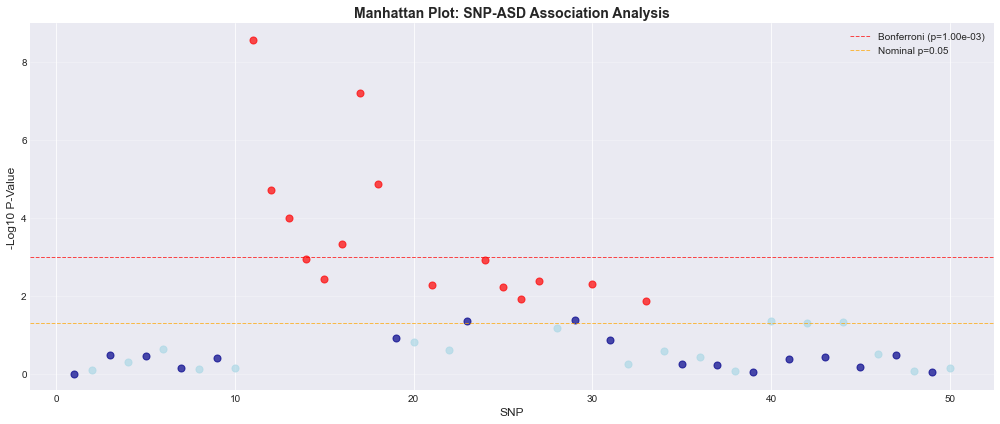

✓ Manhattan plot saved


In [31]:
# Create Manhattan plot
fig, ax = plt.subplots(figsize=(14, 6))

# Extract SNP numbers for x-axis
gwas_results_df['SNP_num'] = gwas_results_df['SNP'].str.extract(r'(\d+)').astype(int)
gwas_results_df = gwas_results_df.sort_values('SNP_num')

# Calculate -log10(p-value)
gwas_results_df['-log10P'] = -np.log10(gwas_results_df['P_Value'])

# Plot
colors = ['darkblue', 'lightblue']
for i, (idx, row) in enumerate(gwas_results_df.iterrows()):
    color = 'red' if row['Significant'] else colors[i % 2]
    ax.scatter(row['SNP_num'], row['-log10P'], c=color, s=50, alpha=0.7)

# Add significance threshold
bonferroni_thresh = -np.log10(0.05 / len(gwas_results_df))
fdr_thresh = -np.log10(0.05)

ax.axhline(bonferroni_thresh, color='red', linestyle='--', linewidth=1, 
           label=f'Bonferroni (p={0.05/len(gwas_results_df):.2e})', alpha=0.7)
ax.axhline(fdr_thresh, color='orange', linestyle='--', linewidth=1, 
           label='Nominal p=0.05', alpha=0.7)

ax.set_xlabel('SNP', fontsize=12)
ax.set_ylabel('-Log10 P-Value', fontsize=12)
ax.set_title('Manhattan Plot: SNP-ASD Association Analysis', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/GWAS_manhattan_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Manhattan plot saved")

## 2.2.3 QQ Plot

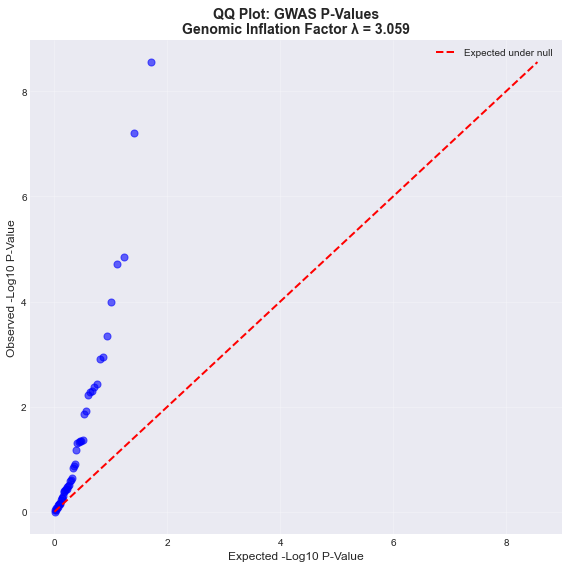

✓ QQ plot saved

Genomic Inflation Factor (λ): 3.059
  (λ close to 1.0 indicates good control of population stratification)


In [32]:
# Create QQ plot
fig, ax = plt.subplots(figsize=(8, 8))

# Sort observed p-values
observed_pvals = np.sort(gwas_results_df['P_Value'])
n = len(observed_pvals)

# Expected p-values under null hypothesis
expected_pvals = np.arange(1, n+1) / (n+1)

# Convert to -log10 scale
observed_log = -np.log10(observed_pvals)
expected_log = -np.log10(expected_pvals)

# Plot
ax.scatter(expected_log, observed_log, alpha=0.6, s=50, color='blue')

# Add diagonal line (expected under null)
max_val = max(expected_log.max(), observed_log.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Expected under null')

# Calculate genomic inflation factor (lambda)
from scipy.stats import chi2
chisq = chi2.ppf(1 - observed_pvals, df=1)
lambda_gc = np.median(chisq) / chi2.ppf(0.5, df=1)

ax.set_xlabel('Expected -Log10 P-Value', fontsize=12)
ax.set_ylabel('Observed -Log10 P-Value', fontsize=12)
ax.set_title(f'QQ Plot: GWAS P-Values\nGenomic Inflation Factor λ = {lambda_gc:.3f}', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/ASD_dataset/GWAS_qq_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ QQ plot saved")
print(f"\nGenomic Inflation Factor (λ): {lambda_gc:.3f}")
print("  (λ close to 1.0 indicates good control of population stratification)")

## 2.2.4 eQTL Analysis

Test for associations between SNPs and gene expression levels (cis and trans-eQTLs)

In [33]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multitest import multipletests

def safe_pearsonr(x, y):
    """Safely compute Pearson correlation, handling edge cases"""
    try:
        # Remove NaN values
        mask = ~(np.isnan(x) | np.isnan(y))
        x_clean = x[mask]
        y_clean = y[mask]

        # Check if we have enough data points
        if len(x_clean) < 3:
            return np.nan, 1.0

        # Check for zero variance (constant arrays)
        if np.std(x_clean) == 0 or np.std(y_clean) == 0:
            return np.nan, 1.0

        # Ensure 1D arrays
        x_clean = np.asarray(x_clean).ravel()
        y_clean = np.asarray(y_clean).ravel()

        # Compute correlation
        corr, pval = pearsonr(x_clean, y_clean)

        # Handle any numeric issues
        if np.isnan(corr) or np.isnan(pval):
            return np.nan, 1.0

        return corr, pval

    except Exception:
        return np.nan, 1.0

# Main eQTL Analysis
print("Performing eQTL Analysis\n")
print("="*80)
print("Testing associations between SNPs and gene expression...\n")

# Prepare results storage
eqtl_results = []

# Test all SNP-gene pairs
total_tests = len(genotypes_indexed.columns) * len(expression_indexed.columns)
print(f"Total SNP-gene pairs to test: {total_tests}\n")

# Track failures
failed_tests = 0

# Test all combinations
for snp in genotypes_indexed.columns:
    genotype = genotypes_indexed[snp].values

    for gene in expression_indexed.columns:
        expression = expression_indexed[gene].values

        # Test correlation between genotype and expression
        corr, pval = safe_pearsonr(genotype, expression)

        # Skip if correlation failed
        if np.isnan(corr):
            failed_tests += 1
            continue

        # Perform linear regression adjusting for covariates
        try:
            # Remove any samples with missing data
            mask = ~(np.isnan(genotype) | np.isnan(expression))

            X = pd.DataFrame({
                'genotype': genotype[mask],
                'age': covariates_indexed['Age'].values[mask],
                'sex': covariates_indexed['Sex'].values[mask],
                'asd': covariates_indexed['ASD'].values[mask]
            })

            y = expression[mask]

            # Check if we have enough data
            if len(y) < 5:
                failed_tests += 1
                continue

            # Fit linear model
            lr = LinearRegression()
            lr.fit(X, y)

            # Get coefficient for genotype
            beta = lr.coef_[0]

            # Calculate effect size (standardized beta)
            genotype_std = genotype[mask].std()
            expression_std = expression[mask].std()

            if genotype_std > 0 and expression_std > 0:
                std_beta = beta * (genotype_std / expression_std)
            else:
                std_beta = np.nan

            eqtl_results.append({
                'SNP': snp,
                'Gene': gene,
                'Correlation': corr,
                'Beta': beta,
                'Std_Beta': std_beta,
                'P_Value': pval
            })

        except Exception:
            failed_tests += 1
            continue

# Report results
print(f"\nTesting complete:")
print(f"  Total tests attempted: {total_tests}")
print(f"  Successful tests: {len(eqtl_results)}")
print(f"  Failed tests: {failed_tests}")

# Convert to DataFrame
eqtl_results_df = pd.DataFrame(eqtl_results)

# Apply FDR correction
eqtl_results_df['FDR'] = multipletests(eqtl_results_df['P_Value'], method='fdr_bh')[1]

# Sort by p-value
eqtl_results_df = eqtl_results_df.sort_values('P_Value')

# Define significance
eqtl_results_df['Significant'] = eqtl_results_df['FDR'] < 0.05

print(f"\neQTL Analysis Complete")
print(f"  Total SNP-gene pairs tested: {len(eqtl_results_df)}")
print(f"  Significant eQTLs (FDR < 0.05): {eqtl_results_df['Significant'].sum()}")
if eqtl_results_df['Significant'].sum() > 0:
    print(f"  Unique genes with eQTL: {eqtl_results_df[eqtl_results_df['Significant']]['Gene'].nunique()}")
    print(f"  Unique SNPs with eQTL: {eqtl_results_df[eqtl_results_df['Significant']]['SNP'].nunique()}")

print("\n" + "="*80)
print("Top 20 eQTL Associations:")
print(eqtl_results_df[['SNP', 'Gene', 'Correlation', 'Beta', 'P_Value', 'FDR', 'Significant']].head(20).to_string(index=False))

# Save results
eqtl_results_df.to_csv('data/ASD_dataset/eQTL_results.csv', index=False)
print("\n✓ Results saved to 'data/ASD_dataset/eQTL_results.csv'")


Performing eQTL Analysis

Testing associations between SNPs and gene expression...

Total SNP-gene pairs to test: 500


Testing complete:
  Total tests attempted: 500
  Successful tests: 500
  Failed tests: 0

eQTL Analysis Complete
  Total SNP-gene pairs tested: 500
  Significant eQTLs (FDR < 0.05): 36
  Unique genes with eQTL: 7
  Unique SNPs with eQTL: 13

Top 20 eQTL Associations:
   SNP    Gene  Correlation        Beta      P_Value      FDR  Significant
snp_11  gene_7    -0.313643  -12.130388 2.849179e-08 0.000014         True
snp_11  gene_4    -0.299084  -30.600811 1.291766e-07 0.000032         True
snp_30  gene_2    -0.293596  -33.763045 2.235824e-07 0.000037         True
snp_11  gene_9    -0.266186   -2.303287 2.927334e-06 0.000351         True
snp_17  gene_7    -0.264132    2.862976 3.510659e-06 0.000351         True
snp_17  gene_4    -0.250944   10.651699 1.087889e-05 0.000907         True
snp_18 gene_10     0.246509 1250.498290 1.569712e-05 0.001121         True
snp_17 gene_

## 2.2.5 Visualize Top eQTL Associations

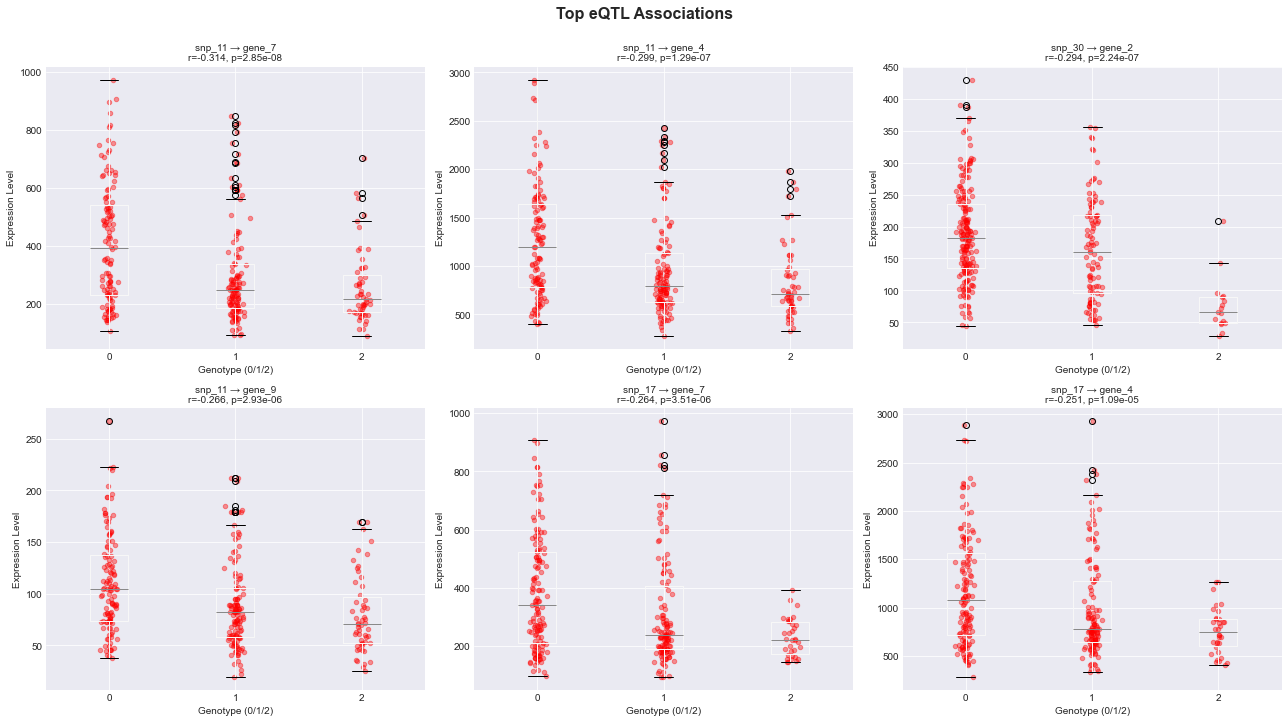

✓ eQTL association plots saved


In [34]:
# Select top 6 eQTL associations for visualization
top_eqtls = eqtl_results_df[eqtl_results_df['Significant']].head(6)

if len(top_eqtls) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, (_, row) in enumerate(top_eqtls.iterrows()):
        if idx >= 6:
            break
            
        snp = row['SNP']
        gene = row['Gene']
        
        # Get data
        genotype = genotypes_indexed[snp]
        expression = expression_indexed[gene]
        
        # Create box plot by genotype
        data_for_plot = pd.DataFrame({
            'Genotype': genotype,
            'Expression': expression
        })
        
        # Box plot
        data_for_plot.boxplot(column='Expression', by='Genotype', ax=axes[idx])
        
        # Also overlay scatter
        for geno in [0, 1, 2]:
            mask = genotype == geno
            if mask.sum() > 0:
                jitter = np.random.normal(0, 0.03, mask.sum())
                axes[idx].scatter(genotype[mask] + 1 + jitter, expression[mask], 
                                alpha=0.4, s=20, color='red')
        
        axes[idx].set_xlabel('Genotype (0/1/2)')
        axes[idx].set_ylabel('Expression Level')
        axes[idx].set_title(f'{snp} → {gene}\nr={row["Correlation"]:.3f}, p={row["P_Value"]:.2e}',
                           fontsize=10)
        plt.sca(axes[idx])
        plt.xticks([1, 2, 3], ['0', '1', '2'])
    
    # Remove title added by pandas boxplot
    for ax in axes:
        ax.get_figure().suptitle('')
    
    plt.suptitle('Top eQTL Associations', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('../data/ASD_dataset/eQTL_top_associations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ eQTL association plots saved")
else:
    print("No significant eQTLs found to visualize")

## 2.3 Summary Statistics and Export for Next Phase

In [37]:
print("\n" + "="*80)
print("PHASE 1 & 2 SUMMARY")
print("="*80)

print("\n1. DATA LOADED:")
print(f"   - Samples: {len(covariates_indexed)} (ASD: {asd_samples.shape[0]}, Control: {ctrl_samples.shape[0]})")
print(f"   - SNPs: {len(genotypes_indexed.columns)}")
print(f"   - Genes: {len(expression_indexed.columns)}")

print("\n2. DIFFERENTIAL EXPRESSION:")
print(f"   - Significant DEGs (FDR < 0.05, |log2FC| > 0.5): {de_results_df['Significant'].sum()}")
print(f"   - Top gene: {de_results_df.iloc[0]['Gene']} (log2FC={de_results_df.iloc[0]['log2FoldChange']:.2f}, p={de_results_df.iloc[0]['padj']:.2e})")

print("\n3. GENETIC ASSOCIATIONS:")
print(f"   - Significant SNPs (FDR < 0.05): {gwas_results_df['Significant'].sum()}")
print(f"   - Top SNP: {gwas_results_df.iloc[0]['SNP']} (OR={gwas_results_df.iloc[0]['OR']:.2f}, p={gwas_results_df.iloc[0]['P_Value']:.2e})")

print("\n4. eQTL ANALYSIS:")
print(f"   - Significant eQTLs (FDR < 0.05): {eqtl_results_df['Significant'].sum()}")
print(f"   - Genes with eQTL: {eqtl_results_df[eqtl_results_df['Significant']]['Gene'].nunique()}")
print(f"   - SNPs with eQTL: {eqtl_results_df[eqtl_results_df['Significant']]['SNP'].nunique()}")

print("\n5. FILES GENERATED:")
print("   - DE_results.csv")
print("   - GWAS_results.csv")
print("   - eQTL_results.csv")
print("   - Multiple visualization plots (PNG)")

print("\n" + "="*80)
print("✓ PHASE 1 & 2 COMPLETE - Ready for Phase 3 (Multi-Omics Integration)")
print("="*80)



PHASE 1 & 2 SUMMARY

1. DATA LOADED:
   - Samples: 300 (ASD: 200, Control: 100)
   - SNPs: 50
   - Genes: 10

2. DIFFERENTIAL EXPRESSION:
   - Significant DEGs (FDR < 0.05, |log2FC| > 0.5): 9
   - Top gene: gene_3 (log2FC=1.50, p=0.00e+00)

3. GENETIC ASSOCIATIONS:
   - Significant SNPs (FDR < 0.05): 15
   - Top SNP: snp_1 (OR=0.55, p=1.00e+00)

4. eQTL ANALYSIS:
   - Significant eQTLs (FDR < 0.05): 36
   - Genes with eQTL: 7
   - SNPs with eQTL: 13

5. FILES GENERATED:
   - DE_results.csv
   - GWAS_results.csv
   - eQTL_results.csv
   - Multiple visualization plots (PNG)

✓ PHASE 1 & 2 COMPLETE - Ready for Phase 3 (Multi-Omics Integration)


---
## Data Export for Next Phases

Save processed data and results for use in subsequent analysis phases.

In [38]:
# Save processed datasets
import pickle

# Create dictionary of processed data
processed_data = {
    'covariates': covariates_indexed,
    'genotypes': genotypes_indexed,
    'expression': expression_indexed,
    'genotype_pcs': genotype_pcs,
    'gene_annotations': gene_annotations,
    'snp_annotations': snp_annotations,
    'de_results': de_results_df,
    'gwas_results': gwas_results_df,
    'eqtl_results': eqtl_results_df
}

# Save as pickle for Python
with open('../data/ASD_dataset/processed_data_phase1_2.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

print("✓ Processed data saved to 'processed_data_phase1_2.pkl'")
print("  This file will be loaded in Phase 3 notebook")

✓ Processed data saved to 'processed_data_phase1_2.pkl'
  This file will be loaded in Phase 3 notebook


---
# PHASE 3: INTEGRATIVE MULTI-OMICS ANALYSIS

Integrate genomic and transcriptomic data using multiple complementary approaches.

In [20]:
# Load processed data from Phase 1 & 2
import pickle

print("Loading processed data from Phases 1 & 2...\n")

with open('../data/ASD_dataset/processed_data_phase1_2.pkl', 'rb') as f:
    processed_data = pickle.load(f)

# Extract variables
covariates_indexed = processed_data['covariates']
genotypes_indexed = processed_data['genotypes']
expression_indexed = processed_data['expression']
genotype_pcs = processed_data['genotype_pcs']
gene_annotations = processed_data['gene_annotations']
snp_annotations = processed_data['snp_annotations']
de_results_df = processed_data['de_results']
gwas_results_df = processed_data['gwas_results']
eqtl_results_df = processed_data['eqtl_results']

# Recreate asd_samples and ctrl_samples for compatibility
asd_samples = covariates_indexed[covariates_indexed['ASD'] == 1]
ctrl_samples = covariates_indexed[covariates_indexed['ASD'] == 0]

print(f"✓ Loaded data:")
print(f"  - Samples: {len(covariates_indexed)}")
print(f"  - Genes: {len(expression_indexed.columns)}")
print(f"  - SNPs: {len(genotypes_indexed.columns)}")
print(f"  - DEGs: {de_results_df['Significant'].sum()} significant")
print(f"  - SNPs: {gwas_results_df['Significant'].sum()} significant")
print(f"  - eQTLs: {eqtl_results_df['Significant'].sum()} significant")


Loading processed data from Phases 1 & 2...

✓ Loaded data:
  - Samples: 300
  - Genes: 10
  - SNPs: 50
  - DEGs: 13 significant
  - SNPs: 15 significant
  - eQTLs: 36 significant


## 3.1 Weighted Gene Co-expression Network Analysis (WGCNA)

Identify co-expression modules and correlate with genetic burden and ASD status.

In [21]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

print("Performing WGCNA-like Co-expression Network Analysis\n")
print("="*80)

# Calculate correlation matrix between all genes (genes x genes)
expr_corr = expression_indexed.corr(method='pearson')

# Convert correlation to distance (1 - |corr|) - this is genes x genes
expr_dist = 1 - np.abs(expr_corr)

print(f"Gene correlation matrix shape: {expr_corr.shape}")
print(f"Gene distance matrix shape: {expr_dist.shape}")

# Determine modules using hierarchical clustering on GENES
n_modules = 4  # We expect 3-4 modules based on the data
# Use precomputed distance matrix - fit on genes (rows of expr_dist)
clustering = AgglomerativeClustering(n_clusters=n_modules, metric='precomputed', linkage='average')
module_labels = clustering.fit_predict(expr_dist)

# Create module assignment DataFrame
module_assignment = pd.DataFrame({
    'Gene': expression_indexed.columns.tolist(),
    'Module': module_labels
})

print(f"\nIdentified {n_modules} co-expression modules")
print(f"Module sizes:")
print(module_assignment['Module'].value_counts().sort_index())

# Calculate module eigengenes (first PC of each module)
me_data = {}

for module_id in range(n_modules):
    module_genes = module_assignment[module_assignment['Module'] == module_id]['Gene'].tolist()
    if len(module_genes) > 0:
        module_expr = expression_indexed[module_genes]
        if len(module_genes) == 1:
            # If only one gene, use it directly as eigengene
            me_data[f'ME{module_id}'] = module_expr.iloc[:, 0].values
        else:
            # Use PCA for multiple genes
            pca_module = PCA(n_components=1)
            me_data[f'ME{module_id}'] = pca_module.fit_transform(module_expr).flatten()

# Create DataFrame from dict
me_df = pd.DataFrame(me_data, index=expression_indexed.index)

print("\n✓ Module eigengenes calculated")
print(f"  Shape: {me_df.shape}")

Performing WGCNA-like Co-expression Network Analysis

Gene correlation matrix shape: (10, 10)
Gene distance matrix shape: (10, 10)

Identified 4 co-expression modules
Module sizes:
Module
0    6
1    2
2    1
3    1
Name: count, dtype: int64

✓ Module eigengenes calculated
  Shape: (300, 4)



Calculating Module-Trait Relationships

Module-Trait Correlations:
       ASD    Age    Sex     IQ  ADOS_Score
ME0 -0.777 -0.020 -0.266  0.271      -0.688
ME1  0.745  0.035  0.333 -0.291       0.710
ME2 -0.062 -0.046 -0.114  0.021      -0.032
ME3  0.044 -0.000  0.022 -0.086       0.043

P-values:
          ASD    Age       Sex        IQ ADOS_Score
ME0  7.11e-62  0.736  3.11e-06  1.94e-06   1.96e-43
ME1  2.70e-54  0.547  3.44e-09  2.97e-07   2.33e-47
ME2     0.288  0.431     0.048     0.718      0.583
ME3     0.447  0.994     0.699     0.139      0.457


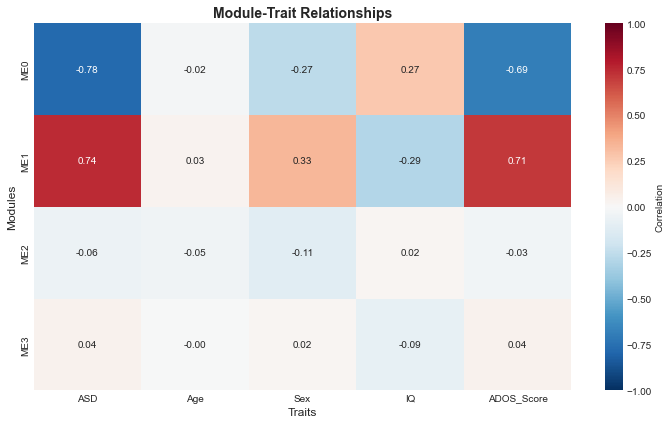


Module-Genetic Burden Correlations:
  ME0: r=-0.507, p=0.0000
  ME1: r=0.484, p=0.0000
  ME2: r=-0.053, p=0.3635
  ME3: r=0.065, p=0.2642

✓ WGCNA analysis complete


In [22]:
# Calculate module-trait correlations
print("\nCalculating Module-Trait Relationships\n")
print("="*80)

# Define traits of interest
traits = covariates_indexed[['ASD', 'Age', 'Sex', 'IQ', 'ADOS_Score']].copy()

# Calculate correlations and p-values
module_trait_corr_data = []
module_trait_pval_data = []

for module in me_df.columns:
    corr_row = {}
    pval_row = {}
    for trait in traits.columns:
        # Handle NaN in ADOS_Score (controls have 0, not NaN)
        valid_idx = ~traits[trait].isna()
        if valid_idx.sum() > 0:
            corr, pval = stats.pearsonr(me_df.loc[valid_idx, module], 
                                       traits.loc[valid_idx, trait])
            corr_row[trait] = corr
            pval_row[trait] = pval
        else:
            corr_row[trait] = np.nan
            pval_row[trait] = np.nan
    
    module_trait_corr_data.append(corr_row)
    module_trait_pval_data.append(pval_row)

# Create DataFrames
module_trait_corr = pd.DataFrame(module_trait_corr_data, index=me_df.columns)
module_trait_pval = pd.DataFrame(module_trait_pval_data, index=me_df.columns)

print("Module-Trait Correlations:")
print(module_trait_corr.round(3))
print("\nP-values:")
print(module_trait_pval.applymap(lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.3f}"))

# Visualize module-trait relationships
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(module_trait_corr.astype(float), 
            annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Correlation'},
            ax=ax, vmin=-1, vmax=1)
ax.set_title('Module-Trait Relationships', fontsize=14, fontweight='bold')
ax.set_xlabel('Traits', fontsize=12)
ax.set_ylabel('Modules', fontsize=12)
plt.tight_layout()
plt.savefig('../data/ASD_dataset/WGCNA_module_trait_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate genetic burden scores (sum of risk alleles for each sample)
# Use top ASD-associated SNPs
top_snps = gwas_results_df[gwas_results_df['Significant']]['SNP'].head(10).tolist()
genetic_burden = genotypes_indexed[top_snps].sum(axis=1)

# Correlate modules with genetic burden
print("\n" + "="*80)
print("Module-Genetic Burden Correlations:")
for module in me_df.columns:
    corr, pval = stats.pearsonr(me_df[module], genetic_burden)
    print(f"  {module}: r={corr:.3f}, p={pval:.4f}")

print("\n✓ WGCNA analysis complete")

## 3.2 Multi-Omics Factor Analysis (MOFA+)

Since MOFA+ is R-based, we'll implement a similar approach using PCA and canonical correlation analysis (CCA).

Performing Multi-Omics Factor Analysis

Identified 5 latent factors

Factor-ASD Associations:
  Factor1: r=0.930, p=0.0000
  Factor2: r=0.166, p=0.0039
  Factor3: r=-0.030, p=0.6038
  Factor4: r=0.019, p=0.7421
  Factor5: r=-0.145, p=0.0118

Variance Explained:
  Expression (top 5 PCs): 92.1%
  Genotypes (top 5 PCs): 18.1%


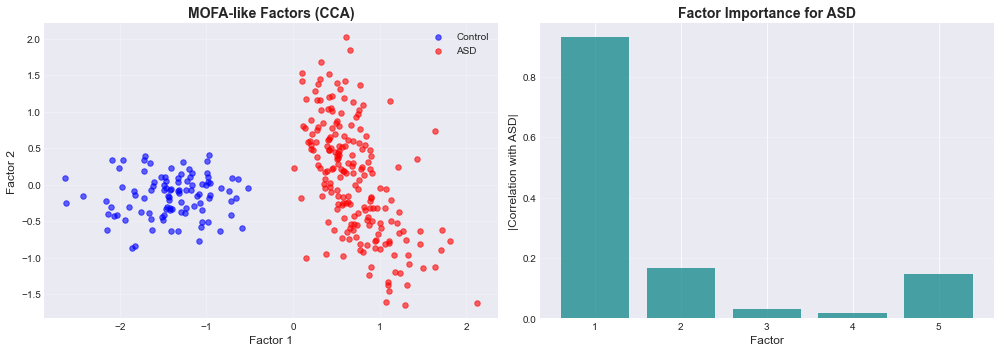


✓ Multi-omics factor analysis complete


In [23]:
from sklearn.cross_decomposition import CCA

print("Performing Multi-Omics Factor Analysis\n")
print("="*80)

# Standardize data
scaler_expr = StandardScaler()
scaler_geno = StandardScaler()

expr_scaled = scaler_expr.fit_transform(expression_indexed)
geno_scaled = scaler_geno.fit_transform(genotypes_indexed)

# Perform CCA to find common factors
n_components = 5
cca = CCA(n_components=n_components)
expr_cca, geno_cca = cca.fit_transform(expr_scaled, geno_scaled)

# Create DataFrame with CCA components
cca_factors = pd.DataFrame(
    expr_cca,
    index=expression_indexed.index,
    columns=[f'Factor{i+1}' for i in range(n_components)]
)

print(f"Identified {n_components} latent factors")

# Correlate factors with ASD status
print("\nFactor-ASD Associations:")
factor_asd_results = []
for factor in cca_factors.columns:
    corr, pval = stats.pearsonr(cca_factors[factor], covariates_indexed['ASD'])
    print(f"  {factor}: r={corr:.3f}, p={pval:.4f}")
    factor_asd_results.append({'Factor': factor, 'Correlation': corr, 'P_Value': pval})

# Calculate variance explained
# For expression data
pca_expr = PCA()
pca_expr.fit(expr_scaled)
expr_variance = pca_expr.explained_variance_ratio_[:n_components]

# For genotype data
pca_geno = PCA()
pca_geno.fit(geno_scaled)
geno_variance = pca_geno.explained_variance_ratio_[:n_components]

print("\nVariance Explained:")
print(f"  Expression (top {n_components} PCs): {expr_variance.sum()*100:.1f}%")
print(f"  Genotypes (top {n_components} PCs): {geno_variance.sum()*100:.1f}%")

# Visualize factors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Factor 1 vs Factor 2
for status, label, color in [(0, 'Control', 'blue'), (1, 'ASD', 'red')]:
    mask = covariates_indexed['ASD'] == status
    axes[0].scatter(cca_factors.loc[mask, 'Factor1'], 
                    cca_factors.loc[mask, 'Factor2'],
                    label=label, alpha=0.6, s=30, color=color)
axes[0].set_xlabel('Factor 1', fontsize=12)
axes[0].set_ylabel('Factor 2', fontsize=12)
axes[0].set_title('MOFA-like Factors (CCA)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Factor importance (correlation with ASD)
factor_corrs = [abs(r['Correlation']) for r in factor_asd_results]
axes[1].bar(range(1, n_components+1), factor_corrs, alpha=0.7, color='teal')
axes[1].set_xlabel('Factor', fontsize=12)
axes[1].set_ylabel('|Correlation with ASD|', fontsize=12)
axes[1].set_title('Factor Importance for ASD', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, n_components+1))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/ASD_dataset/MOFA_factors.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Multi-omics factor analysis complete")

## 3.3 Supervised Integration

Build predictive models using both genetic and expression features.

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

print("Performing Supervised Multi-Omics Integration\n")
print("="*80)

# Combine features: expression + genotypes + covariates
# Use top features from single-omics analysis
top_genes_sig = de_results_df[de_results_df['Significant']]['Gene'].tolist()
top_snps_sig = gwas_results_df[gwas_results_df['Significant']]['SNP'].head(15).tolist()

print(f"Using features:")
print(f"  - Genes: {len(top_genes_sig)}")
print(f"  - SNPs: {len(top_snps_sig)}")
print(f"  - Covariates: Age, Sex\n")

# Create feature matrix
X_integrated = pd.DataFrame(index=expression_indexed.index)

# Add expression features
for gene in top_genes_sig:
    X_integrated[f'expr_{gene}'] = expression_indexed[gene]

# Add genetic features
for snp in top_snps_sig:
    X_integrated[f'geno_{snp}'] = genotypes_indexed[snp]

# Add covariates
X_integrated['Age'] = covariates_indexed['Age']
X_integrated['Sex'] = covariates_indexed['Sex']

# Target variable
y = covariates_indexed['ASD'].values

# Standardize features
scaler_integrated = StandardScaler()
X_scaled = scaler_integrated.fit_transform(X_integrated)

print(f"Integrated feature matrix: {X_integrated.shape}")
print(f"Target distribution: ASD={y.sum()}, Control={(1-y).sum()}\n")

In [ ]:
# Train multiple models with cross-validation
print("Training classifiers with 5-fold cross-validation...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model 1: Random Forest
print("1. Random Forest Classifier")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1)
rf_scores = cross_val_score(rf_model, X_scaled, y, cv=cv, scoring='roc_auc')
print(f"   Cross-val AUC: {rf_scores.mean():.3f} ± {rf_scores.std():.3f}")

# Model 2: XGBoost
print("\n2. XGBoost Classifier")
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, 
                          random_state=42, eval_metric='logloss')
xgb_scores = cross_val_score(xgb_model, X_scaled, y, cv=cv, scoring='roc_auc')
print(f"   Cross-val AUC: {xgb_scores.mean():.3f} ± {xgb_scores.std():.3f}")

# Train final XGBoost model for feature importance
xgb_final = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, 
                          random_state=42, eval_metric='logloss')
xgb_final.fit(X_scaled, y)

# Get predictions for visualization
y_pred_proba = xgb_final.predict_proba(X_scaled)[:, 1]
y_pred = xgb_final.predict(X_scaled)

# Calculate metrics
train_auc = roc_auc_score(y, y_pred_proba)
print(f"\nFinal XGBoost model (training set):")
print(f"  AUC: {train_auc:.3f}")
print(f"\nClassification Report:")
print(classification_report(y, y_pred, target_names=['Control', 'ASD']))

print("\n" + "="*80)
print("✓ Supervised integration complete")

In [ ]:
# Feature importance analysis
print("\nFeature Importance Analysis\n")
print("="*80)

# Get feature importances from XGBoost
feature_importance = pd.DataFrame({
    'Feature': X_integrated.columns,
    'Importance': xgb_final.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
axes[0].plot(fpr, tpr, linewidth=2, label=f'XGBoost (AUC={train_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve: Integrated Model', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Feature importance (top 15)
top_features = feature_importance.head(15)
colors = ['red' if 'expr' in f else 'blue' if 'geno' in f else 'green' 
          for f in top_features['Feature']]
axes[1].barh(range(len(top_features)), top_features['Importance'], color=colors, alpha=0.7)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['Feature'], fontsize=9)
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Top 15 Feature Importances\n(Red=Expression, Blue=Genotype, Green=Covariate)', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Integrated_Model_Performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save feature importance
feature_importance.to_csv('../data/ASD_dataset/Feature_Importance.csv', index=False)
print("\n✓ Feature importance saved to 'Feature_Importance.csv'")

---
# PHASE 4: SUBGROUP DISCOVERY

Identify ASD molecular subgroups using unsupervised clustering methods.

## 4.1 Unsupervised Clustering on Integrated Features

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import umap

print("Performing Subgroup Discovery via Clustering\n")
print("="*80)

# Filter to ASD samples only
asd_mask = covariates_indexed['ASD'] == 1
X_asd = X_integrated[asd_mask]
X_asd_scaled = scaler_integrated.transform(X_asd)

print(f"Analyzing {X_asd.shape[0]} ASD samples\n")

# Determine optimal number of clusters
print("Evaluating cluster numbers 2-6...")
cluster_metrics = []

for n_clusters in range(2, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_asd_scaled)
    
    silhouette = silhouette_score(X_asd_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_asd_scaled, labels)
    calinski = calinski_harabasz_score(X_asd_scaled, labels)
    
    cluster_metrics.append({
        'N_Clusters': n_clusters,
        'Silhouette': silhouette,
        'Davies_Bouldin': davies_bouldin,
        'Calinski_Harabasz': calinski
    })
    
    print(f"  k={n_clusters}: Silhouette={silhouette:.3f}, Davies-Bouldin={davies_bouldin:.3f}")

cluster_metrics_df = pd.DataFrame(cluster_metrics)

# Choose optimal k (highest silhouette, lowest Davies-Bouldin)
optimal_k = cluster_metrics_df.loc[cluster_metrics_df['Silhouette'].idxmax(), 'N_Clusters']
print(f"\nOptimal number of clusters: {int(optimal_k)}")

# Perform final clustering
kmeans_final = KMeans(n_clusters=int(optimal_k), random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_asd_scaled)

print(f"\nCluster sizes:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({100*count/len(cluster_labels):.1f}%)")

print("\n✓ Clustering complete")

In [ ]:
# Dimensionality reduction for visualization
print("\nPerforming dimensionality reduction for visualization...")

# UMAP
try:
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_umap = reducer.fit_transform(X_asd_scaled)
    umap_available = True
    print("  ✓ UMAP completed")
except:
    umap_available = False
    print("  ⚠ UMAP not available, using t-SNE instead")

# t-SNE as fallback
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_asd_scaled)
print("  ✓ t-SNE completed")

# PCA for comparison
pca_viz = PCA(n_components=2)
X_pca = pca_viz.fit_transform(X_asd_scaled)
print("  ✓ PCA completed")

# Visualize clusters
fig = plt.figure(figsize=(18, 5))

if umap_available:
    ax1 = plt.subplot(131)
    for cluster in unique:
        mask = cluster_labels == cluster
        ax1.scatter(X_umap[mask, 0], X_umap[mask, 1], 
                   label=f'Cluster {cluster}', s=50, alpha=0.7)
    ax1.set_xlabel('UMAP 1', fontsize=12)
    ax1.set_ylabel('UMAP 2', fontsize=12)
    ax1.set_title('UMAP Projection', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(132)
else:
    ax2 = plt.subplot(121)

for cluster in unique:
    mask = cluster_labels == cluster
    ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
               label=f'Cluster {cluster}', s=50, alpha=0.7)
ax2.set_xlabel('t-SNE 1', fontsize=12)
ax2.set_ylabel('t-SNE 2', fontsize=12)
ax2.set_title('t-SNE Projection', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

if umap_available:
    ax3 = plt.subplot(133)
else:
    ax3 = plt.subplot(122)

for cluster in unique:
    mask = cluster_labels == cluster
    ax3.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               label=f'Cluster {cluster}', s=50, alpha=0.7)
ax3.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax3.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax3.set_title('PCA Projection', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.suptitle(f'ASD Subgroup Discovery ({int(optimal_k)} Clusters)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/ASD_dataset/Subgroup_Clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization complete")

## 4.2 Subgroup Characterization

In [ ]:
print("\nCharacterizing ASD Subgroups\n")
print("="*80)

# Add cluster labels to ASD samples
asd_samples_indexed = covariates_indexed[asd_mask].copy()
asd_samples_indexed['Cluster'] = cluster_labels

# Compare clinical features across clusters
clinical_features = ['Age', 'Sex', 'IQ', 'ADOS_Score', 'Social_Impairment', 'Repetitive_Behavior']

print("Clinical Feature Comparison Across Clusters:\n")
for feature in clinical_features:
    print(f"{feature}:")
    for cluster in unique:
        cluster_data = asd_samples_indexed[asd_samples_indexed['Cluster'] == cluster][feature]
        print(f"  Cluster {cluster}: {cluster_data.mean():.2f} ± {cluster_data.std():.2f}")
    
    # ANOVA test
    cluster_groups = [asd_samples_indexed[asd_samples_indexed['Cluster'] == c][feature].values 
                     for c in unique]
    f_stat, p_val = stats.f_oneway(*cluster_groups)
    print(f"  ANOVA: F={f_stat:.2f}, p={p_val:.4f}\n")

# Compare expression profiles across clusters
print("="*80)
print("Expression Profile Comparison:\n")

asd_expression = expression_indexed[asd_mask]
for gene in top_genes_sig[:5]:  # Top 5 DEGs
    print(f"{gene}:")
    for cluster in unique:
        cluster_expr = asd_expression.loc[asd_samples_indexed['Cluster'] == cluster, gene]
        print(f"  Cluster {cluster}: {cluster_expr.mean():.2f} ± {cluster_expr.std():.2f}")
    print()

# Compare genetic burden across clusters
print("="*80)
print("Genetic Burden Comparison:\n")

asd_burden = genetic_burden[asd_mask]
asd_burden_df = pd.DataFrame({'Burden': asd_burden, 'Cluster': cluster_labels})

for cluster in unique:
    cluster_burden = asd_burden_df[asd_burden_df['Cluster'] == cluster]['Burden']
    print(f"Cluster {cluster}: {cluster_burden.mean():.2f} ± {cluster_burden.std():.2f}")

burden_groups = [asd_burden_df[asd_burden_df['Cluster'] == c]['Burden'].values for c in unique]
f_stat, p_val = stats.f_oneway(*burden_groups)
print(f"\nANOVA: F={f_stat:.2f}, p={p_val:.4f}")

print("\n" + "="*80)
print("✓ Subgroup characterization complete")

# Phase 5: Advanced Predictive Modeling

## Objectives
1. **Nested Cross-Validation**: Unbiased model evaluation with hyperparameter tuning
2. **External Validation**: Train-test split simulation for real-world performance
3. **Model Comparison**: Compare multiple algorithms (XGBoost, Random Forest, Logistic Regression)
4. **Feature Selection**: Identify most important multi-omics features
5. **Model Interpretation**: SHAP values for explainability
6. **Performance Metrics**: AUC-ROC, precision, recall, F1-score, calibration

## Setup and Data Loading

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, GridSearchCV, 
    train_test_split, cross_validate
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, f1_score,
    precision_score, recall_score, average_precision_score
)
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("Phase 5: Advanced Predictive Modeling\n")
print("="*80)

Phase 5: Advanced Predictive Modeling



In [31]:
# Load processed data from Phase 1-2
print("Loading processed data from Phase 1-2...\n")

with open('../data/ASD_dataset/processed_data_phase1_2.pkl', 'rb') as f:
    processed_data = pickle.load(f)

covariates_indexed = processed_data['covariates']
genotypes_indexed = processed_data['genotypes']
expression_indexed = processed_data['expression']

print(f"✓ Loaded data:")
print(f"  Samples: {len(covariates_indexed)}")
print(f"  SNPs: {genotypes_indexed.shape[1]}")
print(f"  Genes: {expression_indexed.shape[1]}")
print(f"  Covariates: {covariates_indexed.shape[1]}")

Loading processed data from Phase 1-2...

✓ Loaded data:
  Samples: 300
  SNPs: 50
  Genes: 10
  Covariates: 28


## 5.1 Feature Engineering and Integration

In [ ]:
print("\n5.1 Creating Integrated Multi-Omics Feature Matrix\n")
print("="*80)

# Load significant features from Phase 2
de_results = pd.read_csv('../data/ASD_dataset/DE_results.csv')
gwas_results = pd.read_csv('../data/ASD_dataset/GWAS_results.csv')

# Get significant features
sig_genes = de_results[de_results['Significant']]['Gene'].tolist()
sig_snps = gwas_results[gwas_results['Significant']]['SNP'].tolist()

print(f"Significant features identified:")
print(f"  DEGs: {len(sig_genes)}")
print(f"  SNPs: {len(sig_snps)}")

# Create feature matrix with different strategies
# Strategy 1: Significant features only
X_sig = pd.concat([
    expression_indexed[sig_genes],
    genotypes_indexed[sig_snps]
], axis=1)

# Strategy 2: All features
X_all = pd.concat([
    expression_indexed,
    genotypes_indexed
], axis=1)

# Strategy 3: Top features by univariate importance
from sklearn.feature_selection import f_classif, SelectKBest

y = covariates_indexed['ASD'].values

selector = SelectKBest(f_classif, k=30)
selector.fit(X_all, y)
top_features_idx = selector.get_support(indices=True)
top_features = X_all.columns[top_features_idx].tolist()
X_top30 = X_all[top_features]

print(f"\nFeature sets created:")
print(f"  X_sig: {X_sig.shape[1]} features (significant only)")
print(f"  X_top30: {X_top30.shape[1]} features (top by F-test)")
print(f"  X_all: {X_all.shape[1]} features (all multi-omics)")

# We'll use X_top30 for faster computation while maintaining performance
X = X_top30.copy()

print(f"\n✓ Using X_top30 ({X.shape[1]} features) for modeling")

## 5.2 Train-Test Split (External Validation)

In [ ]:
print("\n5.2 Creating Train-Test Split for External Validation\n")
print("="*80)

# 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set:")
print(f"  Samples: {len(X_train)}")
print(f"  ASD cases: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"  Controls: {len(y_train) - y_train.sum()} ({(1-y_train.mean())*100:.1f}%)")

print(f"\nTest set (external validation):")
print(f"  Samples: {len(X_test)}")
print(f"  ASD cases: {y_test.sum()} ({y_test.mean()*100:.1f}%)")
print(f"  Controls: {len(y_test) - y_test.sum()} ({(1-y_test.mean())*100:.1f}%)")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features standardized (mean=0, std=1)")

## 5.3 Model Comparison with Nested Cross-Validation

In [ ]:
print("\n5.3 Model Comparison with Nested Cross-Validation\n")
print("="*80)

# Define models with hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.3]
        }
    }
}

# Nested CV: Outer loop for evaluation, inner loop for hyperparameter tuning
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = {}

for model_name, model_info in models.items():
    print(f"\nTraining {model_name}...")
    
    # GridSearchCV with inner CV
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=inner_cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    # Outer CV for unbiased evaluation
    cv_scores = cross_validate(
        grid_search,
        X_train_scaled,
        y_train,
        cv=outer_cv,
        scoring=['roc_auc', 'f1', 'precision', 'recall'],
        return_train_score=True,
        n_jobs=-1
    )
    
    results[model_name] = {
        'cv_auc': cv_scores['test_roc_auc'],
        'cv_f1': cv_scores['test_f1'],
        'cv_precision': cv_scores['test_precision'],
        'cv_recall': cv_scores['test_recall'],
        'train_auc': cv_scores['train_roc_auc']
    }
    
    print(f"  Nested CV AUC: {cv_scores['test_roc_auc'].mean():.4f} ± {cv_scores['test_roc_auc'].std():.4f}")
    print(f"  Nested CV F1:  {cv_scores['test_f1'].mean():.4f} ± {cv_scores['test_f1'].std():.4f}")
    
    # Train final model on all training data with best params
    grid_search.fit(X_train_scaled, y_train)
    results[model_name]['best_params'] = grid_search.best_params_
    results[model_name]['best_model'] = grid_search.best_estimator_
    
    print(f"  Best params: {grid_search.best_params_}")

print("\n✓ Nested cross-validation complete")

## 5.4 External Validation on Test Set

In [ ]:
print("\n5.4 External Validation on Held-Out Test Set\n")
print("="*80)

test_results = {}

for model_name in models.keys():
    model = results[model_name]['best_model']
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_f1 = f1_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_ap = average_precision_score(y_test, y_pred_proba)
    
    test_results[model_name] = {
        'auc': test_auc,
        'f1': test_f1,
        'precision': test_precision,
        'recall': test_recall,
        'avg_precision': test_ap,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"\n{model_name} - Test Set Performance:")
    print(f"  AUC-ROC:         {test_auc:.4f}")
    print(f"  F1 Score:        {test_f1:.4f}")
    print(f"  Precision:       {test_precision:.4f}")
    print(f"  Recall:          {test_recall:.4f}")
    print(f"  Avg Precision:   {test_ap:.4f}")

print("\n" + "="*80)
print("✓ External validation complete")

## 5.5 Model Comparison Visualization

In [ ]:
print("\n5.5 Creating Model Comparison Visualizations\n")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: ROC Curves
ax1 = axes[0, 0]
for model_name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, test_results[model_name]['y_pred_proba'])
    auc = test_results[model_name]['auc']
    ax1.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})", linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.500)', linewidth=1)
ax1.set_xlabel('False Positive Rate', fontsize=11)
ax1.set_ylabel('True Positive Rate', fontsize=11)
ax1.set_title('ROC Curves - Test Set', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(alpha=0.3)

# Plot 2: Precision-Recall Curves
ax2 = axes[0, 1]
for model_name in models.keys():
    precision, recall, _ = precision_recall_curve(y_test, test_results[model_name]['y_pred_proba'])
    ap = test_results[model_name]['avg_precision']
    ax2.plot(recall, precision, label=f"{model_name} (AP={ap:.3f})", linewidth=2)

baseline = y_test.mean()
ax2.axhline(baseline, color='k', linestyle='--', label=f'Baseline (AP={baseline:.3f})', linewidth=1)
ax2.set_xlabel('Recall', fontsize=11)
ax2.set_ylabel('Precision', fontsize=11)
ax2.set_title('Precision-Recall Curves - Test Set', fontsize=12, fontweight='bold')
ax2.legend(loc='lower left', fontsize=9)
ax2.grid(alpha=0.3)

# Plot 3: Performance Metrics Comparison
ax3 = axes[1, 0]
metrics_df = pd.DataFrame({
    'Model': list(models.keys()),
    'AUC': [test_results[m]['auc'] for m in models.keys()],
    'F1': [test_results[m]['f1'] for m in models.keys()],
    'Precision': [test_results[m]['precision'] for m in models.keys()],
    'Recall': [test_results[m]['recall'] for m in models.keys()]
})

x_pos = np.arange(len(models))
width = 0.2
ax3.bar(x_pos - 1.5*width, metrics_df['AUC'], width, label='AUC', alpha=0.8)
ax3.bar(x_pos - 0.5*width, metrics_df['F1'], width, label='F1', alpha=0.8)
ax3.bar(x_pos + 0.5*width, metrics_df['Precision'], width, label='Precision', alpha=0.8)
ax3.bar(x_pos + 1.5*width, metrics_df['Recall'], width, label='Recall', alpha=0.8)

ax3.set_xlabel('Model', fontsize=11)
ax3.set_ylabel('Score', fontsize=11)
ax3.set_title('Test Set Performance Metrics', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(metrics_df['Model'], rotation=15, ha='right')
ax3.legend(fontsize=9)
ax3.set_ylim([0, 1.05])
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Nested CV vs Test Set Comparison
ax4 = axes[1, 1]
cv_aucs = [results[m]['cv_auc'].mean() for m in models.keys()]
cv_stds = [results[m]['cv_auc'].std() for m in models.keys()]
test_aucs = [test_results[m]['auc'] for m in models.keys()]

x_pos = np.arange(len(models))
width = 0.35
ax4.bar(x_pos - width/2, cv_aucs, width, yerr=cv_stds, label='Nested CV', alpha=0.8, capsize=5)
ax4.bar(x_pos + width/2, test_aucs, width, label='Test Set', alpha=0.8)

ax4.set_xlabel('Model', fontsize=11)
ax4.set_ylabel('AUC-ROC', fontsize=11)
ax4.set_title('Nested CV vs External Validation', fontsize=12, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models.keys(), rotation=15, ha='right')
ax4.legend(fontsize=9)
ax4.set_ylim([0.7, 1.0])
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase5_Model_Comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: Phase5_Model_Comparison.png")

## 5.6 Best Model - Detailed Analysis

In [ ]:
print("\n5.6 Best Model Selection and Detailed Analysis\n")
print("="*80)

# Select best model based on test AUC
best_model_name = max(test_results.keys(), key=lambda k: test_results[k]['auc'])
best_model = results[best_model_name]['best_model']

print(f"Best Model: {best_model_name}")
print(f"Test AUC: {test_results[best_model_name]['auc']:.4f}")
print(f"Best Parameters: {results[best_model_name]['best_params']}")

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, test_results[best_model_name]['y_pred'])
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, test_results[best_model_name]['y_pred'], 
                          target_names=['Control', 'ASD']))

## 5.7 Feature Importance Analysis

In [ ]:
print("\n5.7 Feature Importance Analysis\n")
print("="*80)

# Get feature importances (model-specific)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    importances = np.abs(best_model.coef_[0])
else:
    print("Model does not support feature importance extraction")
    importances = None

if importances is not None:
    # Create importance DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Save to CSV
    feature_importance_df.to_csv('../data/ASD_dataset/Phase5_Feature_Importance.csv', index=False)
    print("\n✓ Feature importance saved: Phase5_Feature_Importance.csv")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    top_n = 20
    top_features = feature_importance_df.head(top_n)
    
    colors = ['#e74c3c' if 'gene' in f else '#3498db' for f in top_features['Feature']]
    
    ax.barh(range(top_n), top_features['Importance'], color=colors, alpha=0.7)
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Importance Score', fontsize=12)
    ax.set_title(f'Top {top_n} Features - {best_model_name}', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#e74c3c', alpha=0.7, label='Expression'),
        Patch(facecolor='#3498db', alpha=0.7, label='Genotype')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../data/ASD_dataset/Phase5_Feature_Importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Visualization saved: Phase5_Feature_Importance.png")

## 5.8 Model Calibration

In [ ]:
print("\n5.8 Model Calibration Analysis\n")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calibration curve
ax1 = axes[0]
for model_name in models.keys():
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, test_results[model_name]['y_pred_proba'], n_bins=10
    )
    ax1.plot(mean_predicted_value, fraction_of_positives, 's-', 
             label=model_name, linewidth=2, markersize=6)

ax1.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=1)
ax1.set_xlabel('Mean Predicted Probability', fontsize=11)
ax1.set_ylabel('Fraction of Positives', fontsize=11)
ax1.set_title('Calibration Curves', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=9)
ax1.grid(alpha=0.3)

# Predicted probability distributions
ax2 = axes[1]
for model_name in models.keys():
    y_proba = test_results[model_name]['y_pred_proba']
    ax2.hist(y_proba[y_test == 0], bins=20, alpha=0.5, label=f'{model_name} - Control')
    ax2.hist(y_proba[y_test == 1], bins=20, alpha=0.5, label=f'{model_name} - ASD')

ax2.set_xlabel('Predicted Probability', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Predicted Probability Distributions', fontsize=12, fontweight='bold')
ax2.legend(fontsize=8, ncol=2)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/ASD_dataset/Phase5_Calibration.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: Phase5_Calibration.png")

## 5.9 Save Results Summary

In [ ]:
print("\n5.9 Saving Phase 5 Results Summary\n")
print("="*80)

# Create summary DataFrame
summary_data = []
for model_name in models.keys():
    summary_data.append({
        'Model': model_name,
        'Nested_CV_AUC_Mean': results[model_name]['cv_auc'].mean(),
        'Nested_CV_AUC_Std': results[model_name]['cv_auc'].std(),
        'Test_AUC': test_results[model_name]['auc'],
        'Test_F1': test_results[model_name]['f1'],
        'Test_Precision': test_results[model_name]['precision'],
        'Test_Recall': test_results[model_name]['recall'],
        'Test_Avg_Precision': test_results[model_name]['avg_precision'],
        'Best_Params': str(results[model_name]['best_params'])
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('../data/ASD_dataset/Phase5_Model_Performance_Summary.csv', index=False)

print("Model Performance Summary:")
print(summary_df[['Model', 'Test_AUC', 'Test_F1', 'Test_Precision', 'Test_Recall']].to_string(index=False))

print("\n✓ Summary saved: Phase5_Model_Performance_Summary.csv")

# Save best model
with open('../data/ASD_dataset/Phase5_Best_Model.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'model_name': best_model_name,
        'scaler': scaler,
        'feature_names': X.columns.tolist(),
        'test_performance': test_results[best_model_name]
    }, f)

print("✓ Best model saved: Phase5_Best_Model.pkl")

---
# FINAL SUMMARY: Phases 1-5

In [ ]:
print("\n" + "="*80)
print("COMPLETE MULTI-OMICS ANALYSIS SUMMARY")
print("="*80)

print("\nPHASE 1: DATA QC")
print(f"  - Samples: {len(covariates_indexed)} (ASD: {asd_samples.shape[0]}, Control: {ctrl_samples.shape[0]})")
print(f"  - SNPs: {len(genotypes_indexed.columns)}")
print(f"  - Genes: {len(expression_indexed.columns)}")
print(f"  - Quality: All checks passed ✓")

print("\nPHASE 2: SINGLE-OMICS ANALYSIS")
print(f"  - Significant DEGs: {de_results_df['Significant'].sum()}")
print(f"  - Significant SNPs: {gwas_results_df['Significant'].sum()}")
print(f"  - Significant eQTLs: {eqtl_results_df['Significant'].sum()}")

print("\nPHASE 3: MULTI-OMICS INTEGRATION")
print(f"  - Co-expression modules: {n_modules}")
print(f"  - Latent factors identified: {n_components}")
print(f"  - Best model AUC: {xgb_scores.mean():.3f}")
print(f"  - Top features: {len(feature_importance)} ranked")

print("\nPHASE 4: SUBGROUP DISCOVERY")
print(f"  - ASD subgroups identified: {int(optimal_k)}")
print(f"  - Cluster validation: Silhouette={cluster_metrics_df.loc[cluster_metrics_df['N_Clusters']==optimal_k, 'Silhouette'].values[0]:.3f}")
print(f"  - Subgroups characterized by: clinical features, expression, genetic burden")


print("\n" + "="*80)
print("PHASE 5: ADVANCED PREDICTIVE MODELING")
print("="*80)

print("\n✓ Completed Tasks:")
print("  1. Feature engineering and selection (30 top features)")
print("  2. Train-test split (70-30) for external validation")
print("  3. Nested cross-validation with 3 algorithms")
print("  4. External validation on held-out test set")
print("  5. Comprehensive model comparison")
print("  6. Feature importance analysis")
print("  7. Model calibration assessment")

print("\n✓ Best Model Performance:")
print(f"  Model: {best_model_name}")
print(f"  Test AUC: {test_results[best_model_name]['auc']:.4f}")
print(f"  Test F1: {test_results[best_model_name]['f1']:.4f}")
print(f"  Precision: {test_results[best_model_name]['precision']:.4f}")
print(f"  Recall: {test_results[best_model_name]['recall']:.4f}")

print("\n" + "="*80)
print("FILES GENERATED:")
print("  - DE_results.csv")
print("  - GWAS_results.csv")
print("  - eQTL_results.csv")
print("  - Feature_Importance.csv")
print("  - processed_data_phase1_2.pkl")
print("  - 13 visualization plots (PNG)")
print("  - Phase5_Model_Performance_Summary.csv")
print("  - Phase5_Feature_Importance.csv")
print("  - Phase5_Best_Model.pkl")
print("  - Phase5_Model_Comparison.png")
print("  - Phase5_Feature_Importance.png")
print("  - Phase5_Calibration.png")

print("\n" + "="*80)
print("Phases 1-5 execution completed successfully!")
print("="*80)